<a href="https://colab.research.google.com/github/VictorBbt/SketchToReality/blob/main/textual_inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning Stable Diffusion using Textual Inversion

## Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/huggingface/diffusers

Cloning into 'diffusers'...
remote: Enumerating objects: 58106, done.
remote: Counting objects: 100% (17582/17582), done.
remote: Compressing objects: 100% (1713/1713), done.
remote: Total 58106 (delta 16814), reused 16113 (delta 15789), pack-reused 40524
Receiving objects: 100% (58106/58106), 39.47 MiB | 22.92 MiB/s, done.
Resolving deltas: 100% (42323/42323), done.


In [3]:
%cd diffusers
!pip install .
%cd examples/dreambooth
!pip install -r requirements.txt
!accelerate config default

/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.28.0.dev0-py3-none-any.whl size=2026598 sha256=d62d11a6c785492120237b4395f4ba7b71cd170749dc4a364909aa27279df295
  Stored in directory: /tmp/pip-ephem-wheel-cache-zzem502b/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
/content/diffusers/examples/dreambooth
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.

In [4]:
!pip install -q diffusers transformers accelerate peft # Trick found online to make it work
!pip install xformers
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
%cd ../textual_inversion/

/content/diffusers/examples/textual_inversion


## Train Textual Inversion

In [ ]:
#train textual inversion

!accelerate launch textual_inversion.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="./../../../drive/MyDrive/SketchToReality/dreambooth_cat" \
  --learnable_property="style" \
  --placeholder_token="<sketch-style>" \
  --initializer_token="sketch" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=3000 \
  --learning_rate=5.0e-04 \
  --scale_lr \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir="./../../../drive/MyDrive/SketchToReality/textual_inversion_cat" \
  --mixed_precision="fp16"


2024-03-16 19:16:50.334726: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 19:16:50.334844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 19:16:50.450027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 19:16:52.105409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
03/16/2024 19:16:53 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer/tokenizer_config.json: 100% 806/806 [00:00<00:00, 4.33MB/s]
toke

# Inference

In [5]:
def save_images(images, filename, path):
  for i, image in enumerate(images):
    image = image.save(path + filename + '_' + str(i) + ".jpg")

In [6]:
from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [8]:
from torch import autocast
from diffusers import StableDiffusionPipeline
import torch

model_id = "./../../../drive/MyDrive/SketchToReality/textual_inversion_cat" #@param {type:"string"}

pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")
pipeline.load_textual_inversion(model_id)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

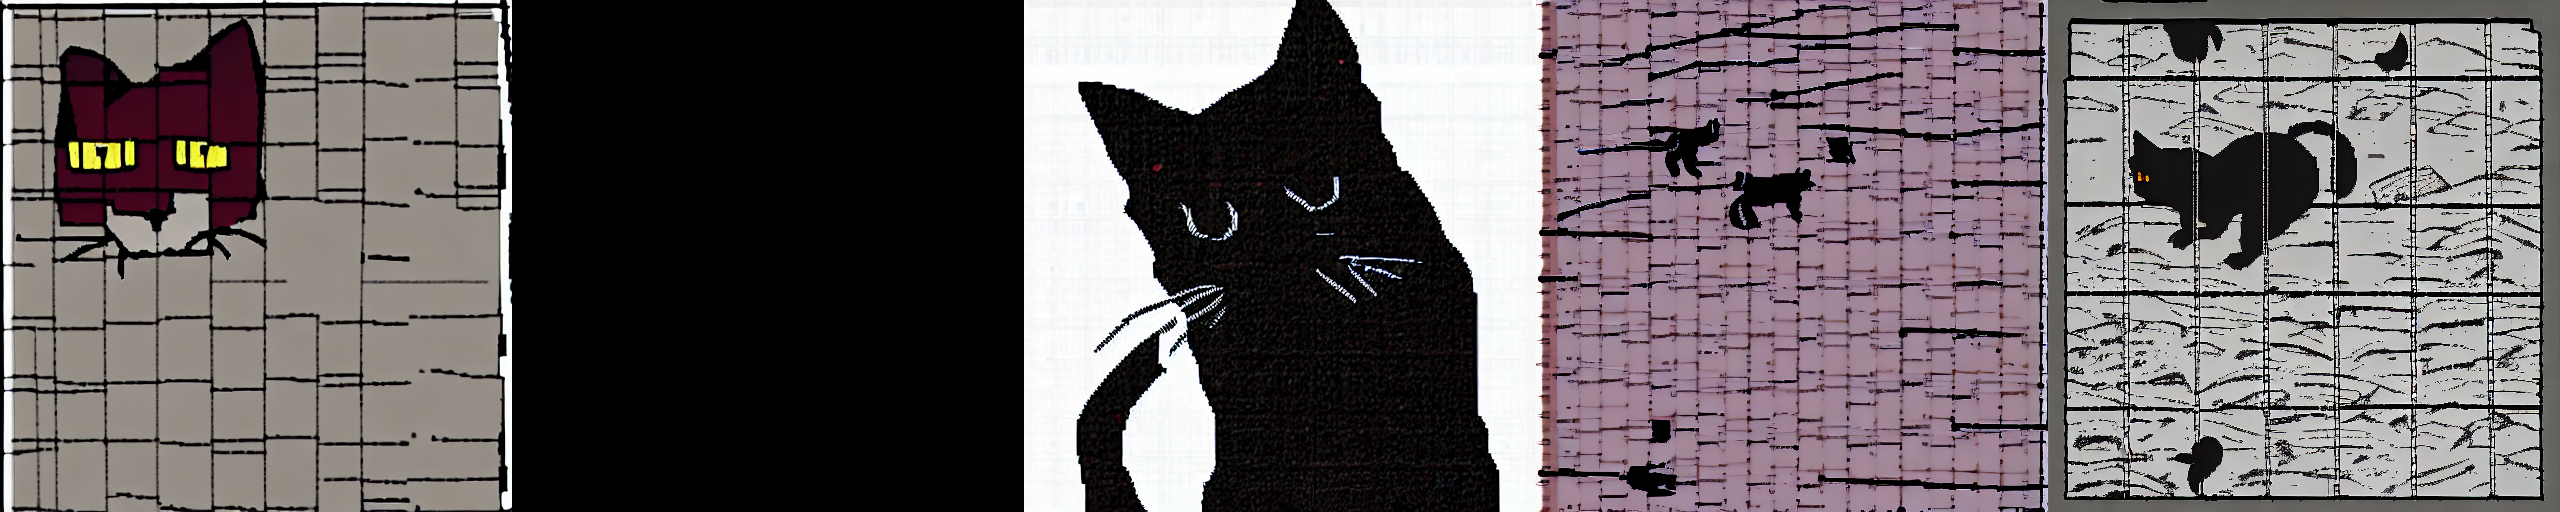

In [9]:
# save few images to drive

from torch import autocast
prompt = "A cat in the style of <sketch-style>" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 5 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    image = pipeline(prompt, num_images_per_prompt=num_samples, num_inference_steps=50).images[0]
    all_images.append(image)

#save_images(all_images, "cat_style_sketch", "./../../../drive/MyDrive/SketchToReality/textual_inversion_cat/generated_images/")
grid = image_grid(all_images, num_samples, num_rows)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


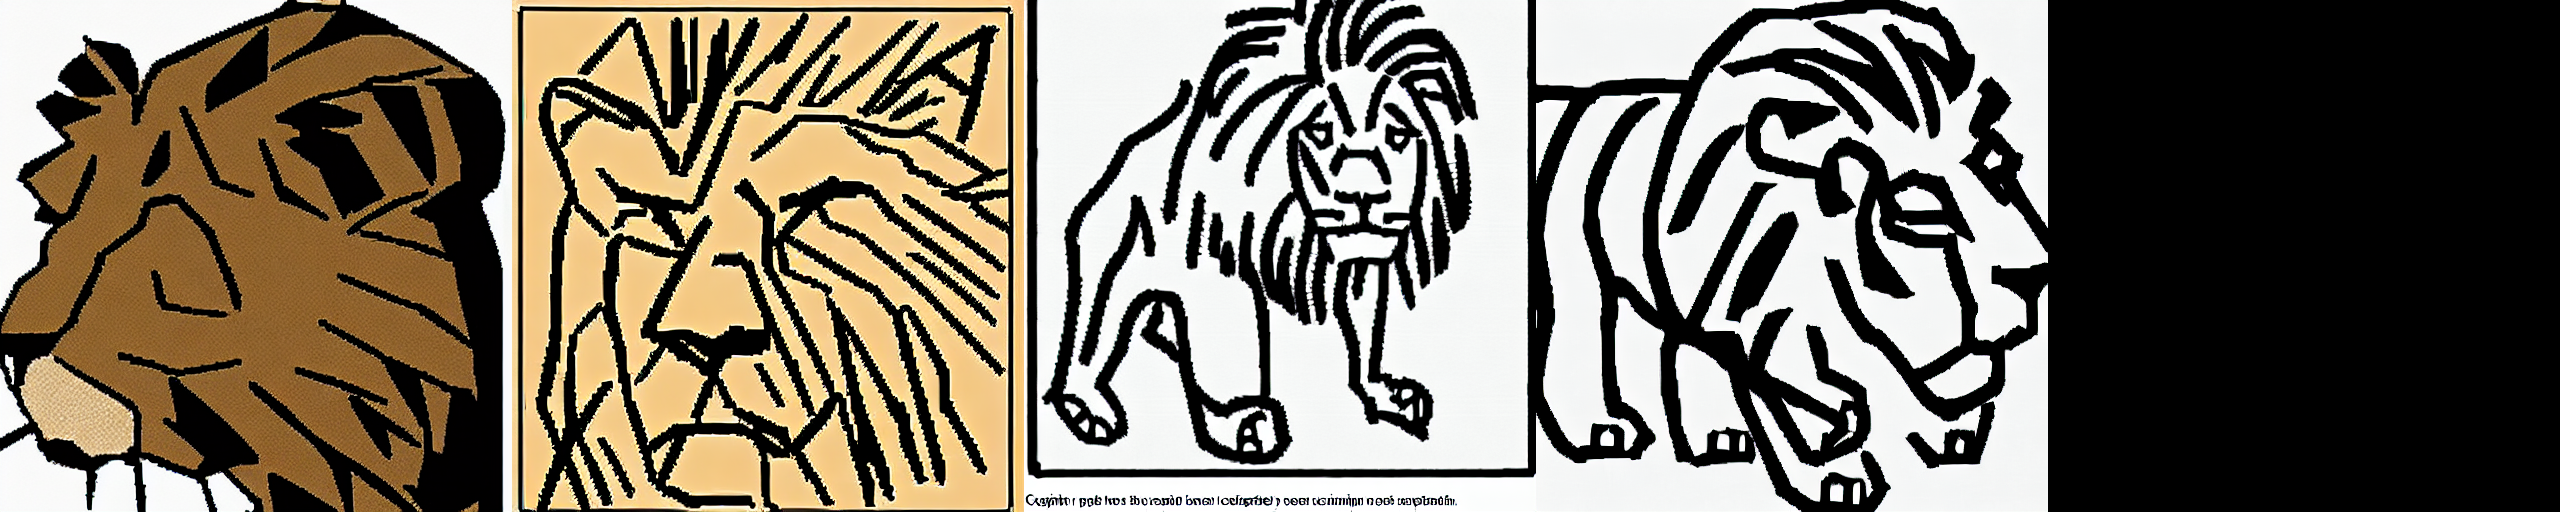

In [10]:
prompt = "A lion in the style of <sketch-style>" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 5 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipeline(prompt, num_images_per_prompt=num_samples, num_inference_steps=50).images[0]
    all_images.append(images)

#save_images(all_images, "lion_style_sketch", "./../../../drive/MyDrive/SketchToReality/textual_inversion_cat/generated_images/")
grid = image_grid(all_images, num_samples, num_rows)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

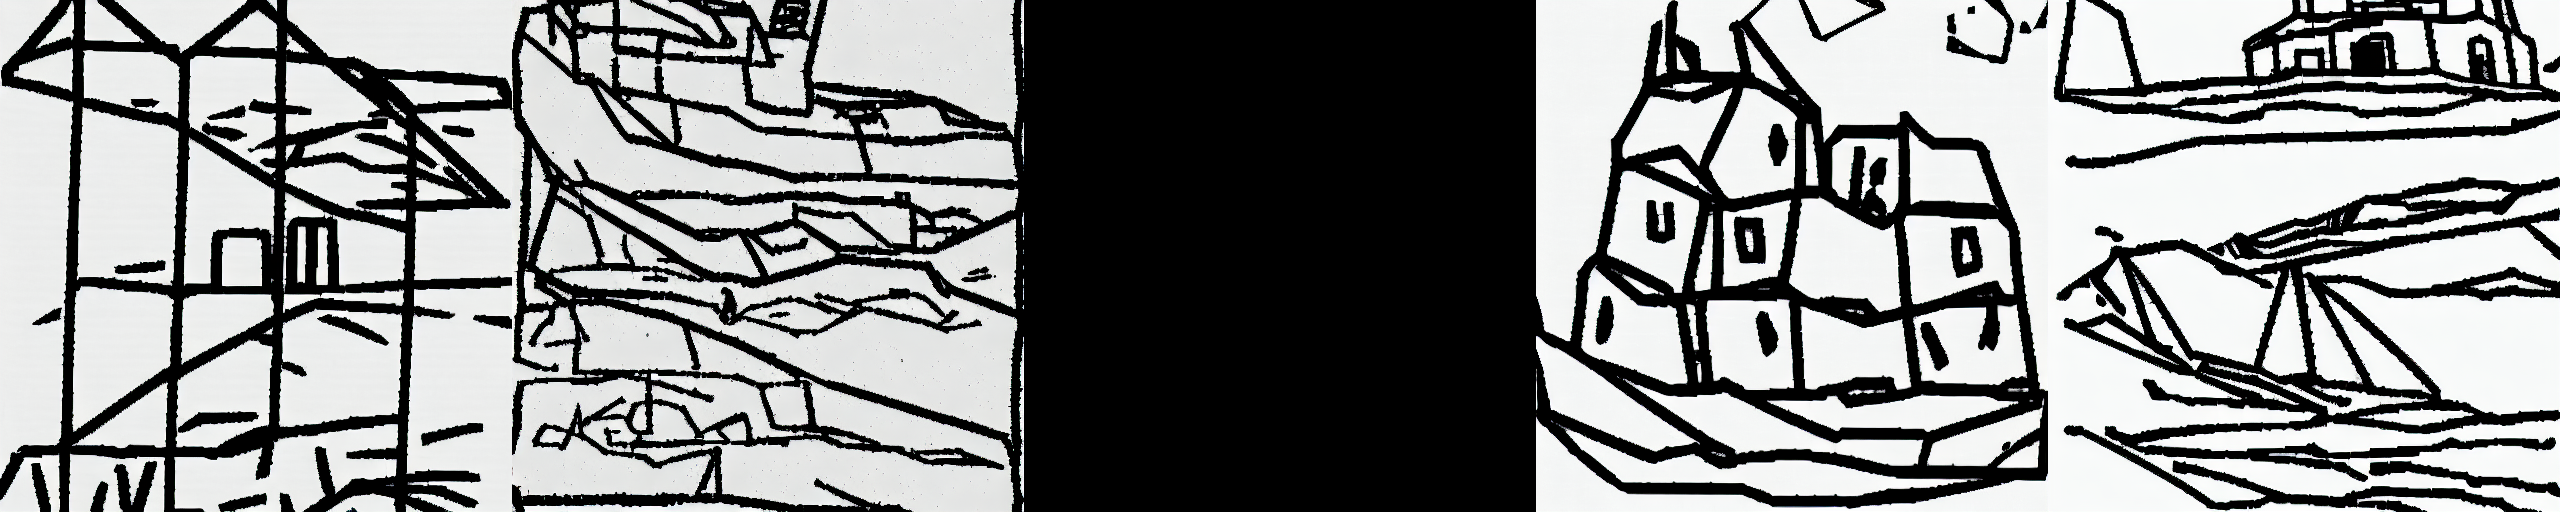

In [11]:
prompt = "A boat in the style of <sketch-style>" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 5 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipeline(prompt, num_images_per_prompt=num_samples, num_inference_steps=50).images[0]
    all_images.append(images)

#save_images(all_images, "boat_style_sketch", "./../../../drive/MyDrive/SketchToReality/textual_inversion_cat/generated_images/")
grid = image_grid(all_images, num_samples, num_rows)
grid

## Evaluate

In [ ]:
import pandas as pd
from PIL import Image
def dataframe_toPILlist(df, show_img = False):
    image_list = []
    label_list = []
    for i in range(df.shape[0]):
        row = df.iloc[i]
        path = row['path']
        lab = row['label']

        img = Image.open(path)
        image_list.append(img)
        label_list.append(lab)

        if show_img:
            print(f'\nLabel {lab}')
            display(img)

    return image_list, label_list

In [ ]:
%cd ../../../drive/MyDrive/SketchToReality/
original_test_dataset_path = './Data/data/sketch/eval_image_captioning.csv'
eval_dataframe = pd.read_csv(original_test_dataset_path)
PILimages, labels = dataframe_toPILlist(eval_dataframe, show_img=False)

In [ ]:
from tqdm import tqdm
import numpy as np

def generate_images(pipe, labels, path, resample_if_nsfw=True):
    generated_images = []
    i = 0
    for l in tqdm(labels):
        prompt = f'A picture of a {l} in the style of sks'
        num_samples=1
        image = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images[0]
        if resample_if_nsfw:
            n_try  =0
            while np.mean(image) == 0 and n_try<=100: # Totally black image, so mean of pixels is 0
                print('NSFW image generated... Trying resampling')
                image = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images[0]
                n_try+=1 # To be sure the algorithm stops, even if the image keeps being nsfw
        generated_images.append(image)
        image_path = path + l + str(i) + ".jpg"
        image = image.save(image_path)
        print(f"saved image {image_path}")
        i = i + 1

    return generated_images

In [ ]:
# generate an image for each label from the eval dataset
generated_images_sks_cat = generate_images(pipeline, labels, 'drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  1%|          | 1/100 [00:07<12:55,  7.84s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/car_(sedan)0.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:15<12:44,  7.80s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/bicycle1.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:23<12:37,  7.81s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/ape2.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 4/100 [00:31<12:32,  7.84s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/racket3.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  5%|▌         | 5/100 [00:39<12:28,  7.88s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/windmill4.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:47<12:34,  8.03s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/rifle5.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  7%|▋         | 7/100 [00:55<12:28,  8.05s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/dolphin6.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  8%|▊         | 8/100 [01:03<12:22,  8.07s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/fan7.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

  9%|▉         | 9/100 [01:11<12:17,  8.10s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/giraffe8.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 10/100 [01:20<12:12,  8.14s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/cat9.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 11%|█         | 11/100 [01:28<12:09,  8.20s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/cat10.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [01:37<12:10,  8.30s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/violin11.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [01:45<12:10,  8.39s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/pretzel12.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [01:54<12:11,  8.50s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/teddy_bear13.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [02:03<12:10,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/sword14.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [02:11<12:02,  8.60s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/dog15.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [02:20<11:53,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/castle16.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [02:28<11:43,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/hamburger17.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [02:37<11:33,  8.56s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/frog18.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 20/100 [02:45<11:23,  8.54s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/hamburger19.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 21%|██        | 21/100 [02:54<11:15,  8.55s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/hat20.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [03:03<11:08,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/crab21.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [03:11<11:00,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/raccoon22.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [03:20<10:53,  8.60s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/alarm_clock23.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [03:29<10:46,  8.62s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/candle24.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [03:37<10:38,  8.63s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/bell25.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [03:46<10:28,  8.61s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/helicopter26.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [03:54<10:19,  8.61s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/raccoon27.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [04:03<10:10,  8.60s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/banana28.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 30/100 [04:12<10:01,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/cow29.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 31%|███       | 31/100 [04:20<09:52,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/duck30.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [04:29<09:43,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/window31.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [04:37<09:34,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/blimp32.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 34%|███▍      | 34/100 [04:46<09:26,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/alarm_clock33.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 35%|███▌      | 35/100 [04:54<09:18,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/rhinoceros34.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 36%|███▌      | 36/100 [05:03<09:09,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/trumpet35.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 37%|███▋      | 37/100 [05:12<09:00,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/armor36.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [05:20<08:52,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/ant37.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 39%|███▉      | 39/100 [05:29<08:42,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/snail38.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NSFW image generated... Trying resampling


  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 40/100 [05:46<11:08, 11.14s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/jellyfish39.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 41%|████      | 41/100 [05:54<10:11, 10.37s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/deer40.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 42%|████▏     | 42/100 [06:03<09:30,  9.83s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/tree41.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 43%|████▎     | 43/100 [06:12<08:59,  9.46s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/bench42.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [06:20<08:34,  9.19s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/wheelchair43.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 45%|████▌     | 45/100 [06:29<08:15,  9.01s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/fan44.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 46%|████▌     | 46/100 [06:37<07:59,  8.88s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/strawberry45.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 47%|████▋     | 47/100 [06:46<07:45,  8.78s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/shark46.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 48%|████▊     | 48/100 [06:54<07:33,  8.73s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/duck47.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 49%|████▉     | 49/100 [07:03<07:22,  8.68s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/candle48.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NSFW image generated... Trying resampling


  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 50/100 [07:20<09:21, 11.22s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/deer49.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 51%|█████     | 51/100 [07:29<08:31, 10.44s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/pretzel50.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 52%|█████▏    | 52/100 [07:37<07:54,  9.88s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/scorpion51.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [07:46<07:26,  9.49s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/bear52.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 54%|█████▍    | 54/100 [07:55<07:04,  9.22s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/cannon53.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 55%|█████▌    | 55/100 [08:03<06:46,  9.03s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/helicopter54.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 56%|█████▌    | 56/100 [08:12<06:31,  8.90s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/pineapple55.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 57%|█████▋    | 57/100 [08:20<06:18,  8.80s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/ape56.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 58%|█████▊    | 58/100 [08:29<06:06,  8.74s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/hedgehog57.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 59%|█████▉    | 59/100 [08:37<05:56,  8.69s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/snake58.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 60/100 [08:46<05:46,  8.67s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/umbrella59.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 61%|██████    | 61/100 [08:55<05:37,  8.64s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/windmill60.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 62%|██████▏   | 62/100 [09:03<05:27,  8.63s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/hamburger61.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 63%|██████▎   | 63/100 [09:12<05:18,  8.61s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/piano62.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 64%|██████▍   | 64/100 [09:20<05:09,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/duck63.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 65%|██████▌   | 65/100 [09:29<05:00,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/camel64.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 66/100 [09:38<04:51,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/bicycle65.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 67%|██████▋   | 67/100 [09:46<04:43,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/church66.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 68%|██████▊   | 68/100 [09:55<04:34,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/shoe67.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 69%|██████▉   | 69/100 [10:03<04:25,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/skyscraper68.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 70/100 [10:12<04:17,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/geyser69.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 71%|███████   | 71/100 [10:20<04:08,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/fan70.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 72%|███████▏  | 72/100 [10:29<04:00,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/butterfly71.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 73%|███████▎  | 73/100 [10:38<03:51,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/deer72.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 74%|███████▍  | 74/100 [10:46<03:42,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/chair73.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 75%|███████▌  | 75/100 [10:55<03:34,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/windmill74.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 76%|███████▌  | 76/100 [11:03<03:25,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/squirrel75.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 77%|███████▋  | 77/100 [11:12<03:17,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/jellyfish76.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 78%|███████▊  | 78/100 [11:20<03:08,  8.57s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/flower77.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 79%|███████▉  | 79/100 [11:29<03:00,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/apple78.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 80/100 [11:38<02:51,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/sword79.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 81%|████████  | 81/100 [11:46<02:42,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/sword80.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 82%|████████▏ | 82/100 [11:55<02:34,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/banana81.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 83%|████████▎ | 83/100 [12:03<02:25,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/motorcycle82.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 84%|████████▍ | 84/100 [12:12<02:17,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/squirrel83.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 85%|████████▌ | 85/100 [12:20<02:08,  8.58s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/sailboat84.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 86%|████████▌ | 86/100 [12:29<02:00,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/hot-air_balloon85.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 87%|████████▋ | 87/100 [12:38<01:51,  8.59s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/ray86.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 88%|████████▊ | 88/100 [12:46<01:43,  8.60s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/butterfly87.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 89%|████████▉ | 89/100 [12:55<01:34,  8.60s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/bell88.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 90%|█████████ | 90/100 [13:03<01:26,  8.60s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/owl89.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


NSFW image generated... Trying resampling


  0%|          | 0/50 [00:00<?, ?it/s]

 91%|█████████ | 91/100 [13:21<01:40, 11.17s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/banana90.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 92%|█████████▏| 92/100 [13:29<01:23, 10.39s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/tree91.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 93%|█████████▎| 93/100 [13:38<01:09,  9.86s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/starfish92.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 94%|█████████▍| 94/100 [13:46<00:56,  9.48s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/pig93.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 95%|█████████▌| 95/100 [13:55<00:46,  9.21s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/bench94.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 96%|█████████▌| 96/100 [14:04<00:36,  9.02s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/sword95.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 97%|█████████▋| 97/100 [14:12<00:26,  8.89s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/bicycle96.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 98%|█████████▊| 98/100 [14:21<00:17,  8.79s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/airplane97.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [14:29<00:08,  8.72s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/duck98.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 100/100 [14:38<00:00,  8.78s/it]

saved image drive/MyDrive/SketchToReality/eval_results/textual_inversion_cat/mouse99.jpg
